In [53]:
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
from scipy.stats import norm
import numpy as np

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import seaborn as sns

import matplotlib.pyplot as plt

## variable noise

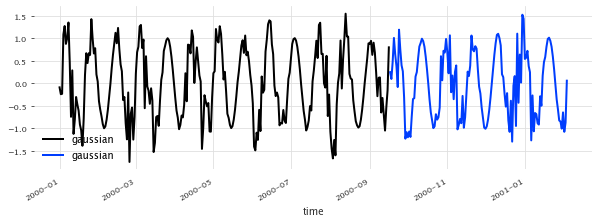

In [3]:

length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02)
    + tg.constant_timeseries(length=length, value=1)
) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

plt.figure(figsize=(10, 3))
target_train.plot()
target_val.plot()

## Fit a model

In [4]:
deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=20,
    kernel_size=2,
    num_filters=4,
    dilation_base=2,
    dropout=0,
    random_state=0,
    likelihood=GaussianLikelihood(),
)

deeptcn.fit(target_train, past_covariates=covariates, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

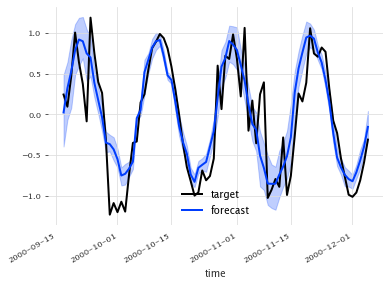

In [5]:
pred = deeptcn.predict(80, past_covariates=covariates, num_samples=100)
target_val.slice_intersect(pred).plot(label="target")
pred.plot(label="forecast")

In [8]:
pred.n_components

1

In [14]:
pred.width

1

In [22]:
pred[0]

<TimeSeries (DataArray) (time: 1, component: 1, sample: 100)>
array([[[ 8.30396740e-02, -3.88753281e-01, -6.24434558e-02,
         -7.84073390e-02,  6.25561451e-02,  4.53372955e-02,
         -2.66049969e-01, -2.03494792e-01, -4.75436679e-01,
          1.22382117e-01, -6.07878667e-02,  5.97746159e-02,
          2.67404059e-01, -6.12185650e-02,  2.18402467e-01,
         -5.11989452e-01,  2.20956626e-01, -2.00116385e-01,
          4.85527860e-01,  3.74198714e-01,  5.21156105e-01,
         -1.75691952e-01, -3.92050560e-01,  5.92824067e-02,
          2.84656767e-01, -2.97355951e-01,  2.77795758e-01,
          2.42140847e-02, -5.67498361e-01, -2.76123610e-02,
          1.32580461e-01,  1.01877411e-01, -1.35373741e-02,
          6.36703414e-01, -4.04743046e-04,  1.48938221e-01,
         -4.14676524e-01,  3.06811449e-01, -1.48811387e-01,
          6.44280253e-02, -2.80083607e-02,  4.19760686e-01,
          1.34081917e-01, -3.45963568e-01,  2.30484701e-01,
         -2.73991069e-01,  1.25714404e-01, -4.14875100e-01,
          5.94054757e-01, -2.02681899e-01,  6.82195835e-02,
         -1.93249378e-01, -2.49530488e-01,  2.12861092e-03,
          4.20631460e-01, -2.26230320e-01, -1.55079396e-01,
          5.06543037e-02, -2.06515352e-01,  1.55456840e-02,
         -8.15854879e-02,  1.63439608e-01,  2.41466849e-02,
          4.86922203e-01, -1.46321052e-01, -1.79880886e-01,
          2.00609569e-01,  1.35019486e-01,  4.98454150e-01,
          3.10303114e-01,  2.31827322e-01,  6.69070763e-03,
         -2.51545668e-01, -1.44896047e-01,  1.88324348e-01,
          3.68385871e-01, -1.73447359e-01,  1.19563575e-01,
          1.47280132e-01, -1.42803943e-01,  4.40448881e-01,
         -2.11258959e-01, -1.35274837e-01, -2.22415736e-01,
          1.40142175e-01, -1.21537766e-01,  2.23081501e-02,
         -6.97335591e-03,  1.51065732e-01,  2.65319566e-02,
         -3.64473930e-02,  7.72397547e-02,  2.72816773e-02,
          8.82797078e-02,  4.88003983e-02, -3.69559842e-01,
         -1.91617052e-01,  6.47286358e-02,  2.61415105e-01,
         -1.58794025e-01]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-09-17
  * component  (component) object 'gaussian'
Dimensions without coordinates: sample

In [47]:
pred_numpy = pred.data_array().to_numpy()

In [50]:
pdf = norm.pdf(pred_numpy[0] , loc = np.mean(pred_numpy[0] ) , scale = np.var(pred_numpy[0] ) )
 

<AxesSubplot:ylabel='Density'>

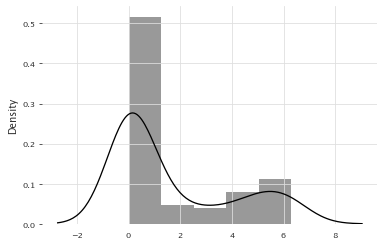

In [54]:
sns.distplot(pdf)

In [55]:
np.percentile(pdf, 50) # return 50th percentile, e.g median.

0.16114881362475864

In [56]:
np.percentile(pdf, 75) # return 50th percentile, e.g median.

3.346940756796614

In [57]:
np.percentile(pdf, 25) # return 50th percentile, e.g median.

0.0006682991766412223